In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
from minio import Minio
import rasterio
import pyproj
from shapely.geometry import Point
import requests
import warnings
from skgstat import Variogram

warnings.filterwarnings('default')

# os.environ['PROJ_LIB'] = '/opt/conda/share/proj'
folder = '/home/opengeohub/xuemeng/work_xuemeng/soc'
# /home/opengeohub/.local/bin

### calculate variogram
- calculate the distance, and differences between all data pairs
- get variogram, and reverse it to get 
- fix the issue of double points in the same spatial location
- overlay with predicted values

In [2]:
factor = np.sqrt(1.465) #, inflation factor

# calculate the distances between data pairs
dfv = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/data_ocd.variogram.depth.aggregated.csv', low_memory=False)
# dfv = dfv.loc[dfv['std_rsd']>-3]
dfv['std_rsd'] = dfv['std_rsd']/factor
gdf = gpd.GeoDataFrame(dfv, geometry=gpd.points_from_xy(dfv['lon'], dfv['lat']), crs="EPSG:4326")
gdft = gdf#.iloc[0:500]

gdf_utm32n = gdft.to_crs(epsg=32632)
gdf_utm32n = gdf_utm32n.reset_index(drop=True)

In [3]:
import numpy as np

all_dists = []
all_diffs = []
ms = []
for index, row in gdf_utm32n.iterrows():
    iii = index + 1
    reference_point = gdf_utm32n.iloc[index].geometry
    dists = gdf_utm32n.iloc[iii:].geometry.distance(reference_point).values / 1000
    reference_values = gdf_utm32n.iloc[index]['std_rsd']
    diffs = (gdf_utm32n.iloc[iii:]['std_rsd'] - reference_values) ** 2 / 2
    ms.append(len(diffs))
    # print(ms)
    
    all_dists.extend(dists)
    all_diffs.extend(diffs)

all_dists = np.array(all_dists)
all_diffs = np.array(all_diffs)

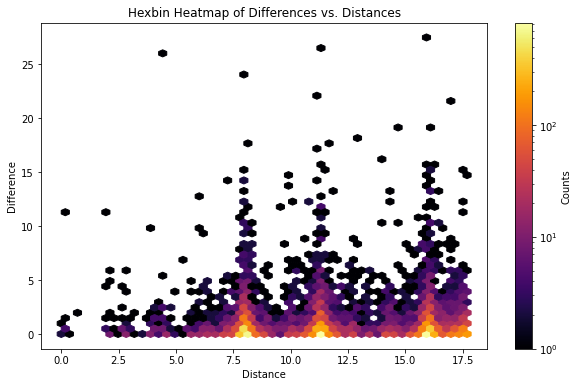

In [4]:
import matplotlib.pyplot as plt

# Ensure the data is sorted
all_dists_sorted = np.array(all_dists)[np.argsort(all_dists)]
all_diffs_sorted = np.array(all_diffs)[np.argsort(all_dists)]

# Create a hexbin plot
plt.figure(figsize=(10, 6))
hb = plt.hexbin(all_dists_sorted[0:10000], all_diffs_sorted[0:10000], gridsize=50, bins='log',cmap='inferno', mincnt=1)
# plt.xlim([0,20])
# Add color bar to indicate the counts in the hexagons
cb = plt.colorbar(hb, label='Counts')

# Labels and title
plt.xlabel('Distance')
plt.ylabel('Difference')
plt.title('Hexbin Heatmap of Differences vs. Distances')

# Show plot
plt.show()


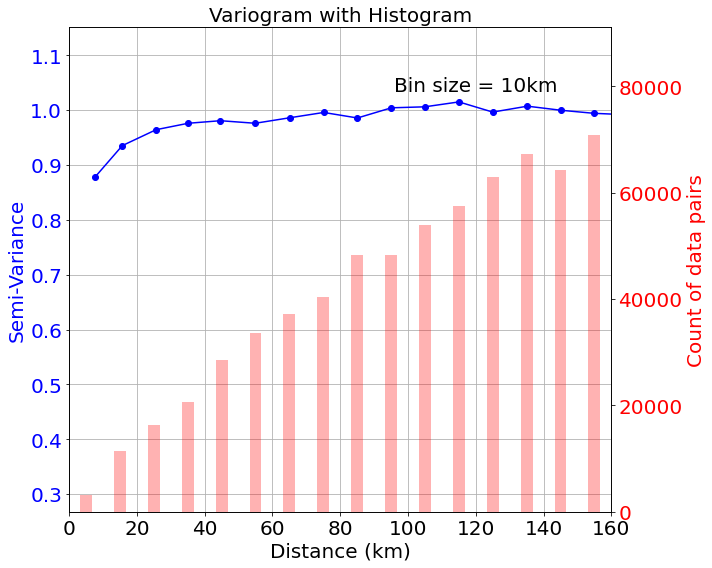

In [5]:
bins_size = 10
bin_edges = np.arange(0, max(all_dists), bins_size)  # Bins from 0 km to the max distance, in 1 km increments
bin_indices = np.digitize(all_dists, bin_edges)

# binned_distances = np.zeros(len(bin_edges) - 1)
binned_variograms = np.zeros(len(bin_edges) - 1)
binned_dist = np.zeros(len(bin_edges) - 1)
binned_number = np.zeros(len(bin_edges) - 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoint of each bin

for i in range(1, len(bin_edges)):
    # Select data in the current bin
    mask = bin_indices == i
    binned_number[i - 1] = np.sum(mask)
    if np.sum(mask) > 0:
        binned_dist[i - 1] = np.nanmean(all_dists[mask])  # Average semi-variance for this bin
        binned_variograms[i - 1] = np.nanmean(all_diffs[mask])  # Average semi-variance for this bin

# Removing bins with zero count
mask_nonzero = binned_number > 0

# Filter the data
filtered_binned_variograms = binned_variograms[mask_nonzero]
filtered_binned_dist = binned_dist[mask_nonzero]
filtered_binned_number = binned_number[mask_nonzero]
filtered_bin_centers = bin_centers[mask_nonzero]

fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.plot(filtered_binned_dist, filtered_binned_variograms, marker='o', linestyle='-', color='b', label='Variogram')
ax1.set_xlabel('Distance (km)', fontsize=20)
# ax1.set_xlim([0, 200])
ax1.set_ylabel('Semi-Variance', color='b', fontsize=20)
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.6, 0.9, f'Bin size = {bins_size}km', 
            ha='left', va='top', transform=ax1.transAxes, fontsize=20)  # Adjusted text position

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(filtered_bin_centers, filtered_binned_number, width=3.5, alpha=0.3, color='r', label='Histogram')
ax2.set_ylabel('Count of data pairs', color='r', fontsize=20)
ax2.tick_params(axis='y', labelcolor='r', labelsize=20)

plt.title('Variogram with Histogram', fontsize=20)
ax1.grid(True)
ax1.set_xlim([0,160])
# ax1.set_ylim([0,1])
fig.tight_layout()  # adjust subplots to fit into figure area.

plt.show()

### theoretical variogram and correlation function

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Filter the empirical data to only include distances <= 150 km
mask_150 = filtered_binned_dist <= 150
filtered_distances = filtered_binned_dist[mask_150]
filtered_variograms = filtered_binned_variograms[mask_150]

# Define variogram models
def spherical_model(h, nugget, sill, range_):
    return np.where(h < range_, nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3), sill)

def exponential_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-h / range_))

def gaussian_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(- (h**2) / (range_**2)))

# Use curve_fit to fit the empirical variogram data to a model
def fit_variogram_model(model, h, gamma):
    # Initial guess for parameters: nugget, sill, range
    initial_params = [0.1, 1.0, 10.0]
    
    # Fit the model to the data
    params, _ = curve_fit(model, h, gamma, p0=initial_params)
    
    return params

def correlation_function(h, nugget, sill, range_):
    # Calculate the variogram value at distance h
    gamma_h = exponential_model(h, nugget, sill, range_)
    # Calculate and return the correlation function value
    return (sill - gamma_h) / sill

# y = correlation_function(distance, *params_exponential)

params_spherical = fit_variogram_model(spherical_model, filtered_distances, filtered_variograms)
params_exponential = fit_variogram_model(exponential_model, filtered_distances, filtered_variograms)
params_gaussian = fit_variogram_model(gaussian_model, filtered_distances, filtered_variograms)

# Generate the fitted variogram lines within the range [0, 150] km
h_vals = np.linspace(0, 150, 300)
fitted_variogram_spherical = spherical_model(h_vals, *params_spherical)
fitted_variogram_exponential = exponential_model(h_vals, *params_exponential)
fitted_variogram_gaussian = gaussian_model(h_vals, *params_gaussian)


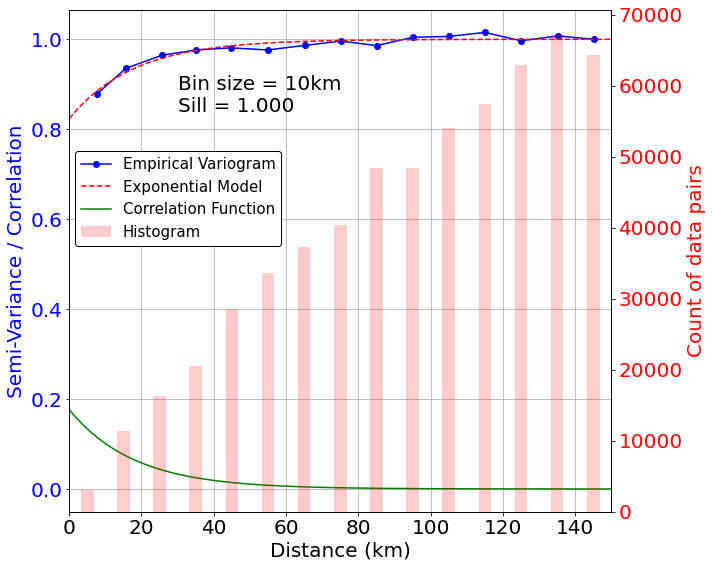

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the variogram, exponential model, and other functions have been defined previously

# Generate the correlation function values using the exponential model
correlation_values = correlation_function(h_vals, *params_exponential)

fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot empirical variogram for the range [0, 150]
ax1.plot(filtered_distances, filtered_variograms, marker='o', linestyle='-', color='b', label='Empirical Variogram')

# Plot the exponential model
ax1.plot(h_vals, fitted_variogram_exponential, linestyle='--', color='r', label='Exponential Model')

# # Plot fitted spherical and Gaussian models (optional, if you want to compare)
# ax1.plot(h_vals, fitted_variogram_spherical, linestyle='--', color='g', label='Spherical Model')
# ax1.plot(h_vals, fitted_variogram_gaussian, linestyle='--', color='orange', label='Gaussian Model')

# Plot the correlation function on the same axis as the semi-variance
ax1.plot(h_vals, correlation_values, linestyle='-', color='green', label='Correlation Function')

# Set labels and titles
ax1.set_xlabel('Distance (km)', fontsize=20)
ax1.set_ylabel('Semi-Variance / Correlation', color='b', fontsize=20)  # Shared y-axis label
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.2, 0.87, f'Bin size = {bins_size}km\nSill = {params_exponential[1]:.3f}', 
         ha='left', va='top', transform=ax1.transAxes, fontsize=20)  # Adjusted text position
ax1.grid(True)
ax1.set_xlim([0, 150])

# Plot the histogram on the secondary y-axis
ax2 = ax1.twinx()
ax2.bar(filtered_bin_centers[mask_150], filtered_binned_number[mask_150], width=3.5, alpha=0.2, color='r', label='Histogram')
ax2.set_ylabel('Count of data pairs', color='r', fontsize=20)
ax2.tick_params(axis='y', labelcolor='r', labelsize=20)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=(0.01,0.53), fontsize=15, facecolor='white', edgecolor='black', framealpha=1)

# Final layout adjustments
fig.tight_layout()
plt.savefig("/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/plot_variogram_corrected.pdf", format='pdf',dpi=300)

# Show the plot
plt.show()


### calculate the variance of a region 
- select 'Unterallgäu' and 'Memmingen, Kreisfreie Stadt' due to data availbility and district size
- sub-sample (if necessary),500m, could also be 1km

In [56]:
from shapely import wkt
temp = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/data_subsample.ocd.variogram.csv',low_memory=False)
temp['geometry'] = temp['geometry'].apply(wkt.loads)
cols_to_be_scaled = ['ocd_p025_2004.2008', 'ocd_m_2000.2004',
       'ocd_p025_2020.2022', 'ocd_m_2004.2008', 'ocd_p025_2012.2016',
       'ocd_p025_2016.2020', 'ocd_p025_2000.2004', 'ocd_m_2016.2020',
       'ocd_p025_2008.2012', 'ocd_p975_2004.2008', 'ocd_p975_2008.2012',
       'ocd_p975_2020.2022', 'ocd_m_2008.2012', 'ocd_m_2012.2016',
       'ocd_p975_2012.2016', 'ocd_m_2020.2022', 'ocd_p975_2016.2020',
       'ocd_p975_2000.2004', 'ocd_std_2000.2004', 'ocd_std_2004.2008',
       'ocd_std_2008.2012', 'ocd_std_2012.2016', 'ocd_std_2016.2020',
       'ocd_std_2020.2022']
for col in cols_to_be_scaled:
    temp[col] = temp[col]/10
    if '_std_' in col:
        temp[col] = temp[col]*factor
    
    
gdf = gpd.GeoDataFrame(temp, geometry=temp['geometry'], crs="EPSG:3035")
gdft = gdf  # .iloc[0:500]
# Reproject to UTM zone 32N
gdf_utm32n = gdft.to_crs(epsg=32632)
gdf_utm32n = gdf_utm32n.reset_index(drop=True)

In [57]:

### organize data pairs
ty = time[0]
agg_var = []
agg_var2 = []
for ty in time:
    ttprint(ty)
    all_dists = []
    ms = []
    pnt1 = []
    pnt2 = []
    std1 = []
    std2 = []
    rho = []

    for index, row in gdf_utm32n.iterrows():
        iii = index + 1
        reference_point = gdf_utm32n.iloc[index].geometry
        dists = gdf_utm32n.iloc[iii:].geometry.distance(reference_point).values / 1000

        pnt1.extend([gdf_utm32n.iloc[index]['id']] * len(dists))
        pnt2.extend(gdf_utm32n.iloc[iii:]['id'].values.tolist())

        std1.extend([gdf_utm32n.iloc[index][f'ocd_std_{ty}']] * len(dists))
        std2.extend(gdf_utm32n.iloc[iii:][f'ocd_std_{ty}'].values.tolist())

        rho.extend(correlation_function(dists, *params_exponential))

        ms.append(len(dists))  # Corrected to use dists instead of diffs
        all_dists.extend(dists)
        
    print(len(rho))
    rho = rho*2
    std1 = std1*2
    std2 = std2*2
    
    print(len(rho))
    rho.extend([1]*len(gdf_utm32n))
    std1.extend(gdf_utm32n[f'ocd_std_{ty}'].values.tolist())
    std2.extend(gdf_utm32n[f'ocd_std_{ty}'].values.tolist())
    
    print(len(rho))
    rho_array = np.array(rho)
    std1_array = np.array(std1)
    std2_array = np.array(std2)

    agg_var.append(np.nansum(rho_array * std1_array * factor * std2_array * factor)/len(temp)**2)
    agg_var2.append(np.nansum(rho_array * std1_array * factor * std2_array * factor)/len(rho_array))


[14:46:40] 2000.2004
15398475
30796950
30802500
[14:47:21] 2004.2008
15398475
30796950
30802500
[14:48:05] 2008.2012
15398475
30796950
30802500
[14:48:46] 2012.2016
15398475
30796950
30802500
[14:49:28] 2016.2020
15398475
30796950
30802500
[14:50:11] 2020.2022
15398475
30796950
30802500


In [60]:
nuts_eg = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_example_slope.csv',low_memory=False)

for col in ['ocd_m','ocd_p025','ocd_p975']:
    nuts_eg[col] = nuts_eg[col]/10

nuts_eg['agg_var'] = agg_var2
nuts_eg['agg_std'] = np.sqrt(nuts_eg['agg_var'])
# nuts_eg['mean_std'] = (nuts_eg['ocd_p975'] - nuts_eg['ocd_p025'])*factor/4
nuts_eg

,year,time,ocd_m,ocd_p025,ocd_p975,agg_var,agg_std
0,2002,2000.2004,35.170661,20.540599,61.423062,12.916204,3.593912
1,2006,2004.2008,34.123062,19.703209,59.803357,12.372567,3.517466
2,2010,2008.2012,34.418549,20.913788,59.007742,11.280202,3.358601
3,2014,2012.2016,34.151245,20.999266,58.221672,10.807694,3.287506
4,2018,2016.2020,33.546105,20.444527,57.722154,10.709219,3.272494
5,2021,2020.2022,33.261574,20.076924,57.873950,10.979347,3.313510


### design-based variance

In [92]:
# nuts3.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/sample_ocd.depth.aggregated.csv')

In [61]:
de = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/data_ocd.depth.aggregated.csv',low_memory=False)
geometry = [Point(xy) for xy in zip(de['lon'], de['lat'])]
de = gpd.GeoDataFrame(de, geometry=geometry, crs="EPSG:4326")
de = de.to_crs("EPSG:3035")

rg = gpd.read_file('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3_example_slope.gpkg')

nuts3 = gpd.sjoin(de, rg, predicate='within')
nuts3 = nuts3.drop(columns=['index_right'])

# dbv = pd.DataFrame(columns=['time','mean','var','sample_size'])
# for tt in nuts3['time'].unique():
#     tempp = nuts3.loc[nuts3['time']==tt]
#     ll = len(tempp)
#     if ll<=1:
#         continue
        
#     mmean = tempp['ocd'].mean()
#     vvar = np.sum((tempp['ocd']-mmean)**2)/ll/(ll-1)
    
#     dbv.loc[len(dbv)] = [tt,mmean,vvar,ll]

ll = len(nuts3)
mmean = nuts3['ocd'].mean()
vvar = np.sum((nuts3['ocd']-mmean)**2)/ll/(ll-1)

nuts_eg['sample_mean'] = [np.nan,np.nan,np.nan,mmean,np.nan,np.nan]
nuts_eg['sample_var'] = [np.nan,np.nan,np.nan,vvar,np.nan,np.nan]
nuts_eg['sample_size'] = [0,0,0,ll,0,0]
nuts_eg['sample_std'] = np.sqrt(nuts_eg['sample_var'])
nuts_eg

,year,time,ocd_m,ocd_p025,ocd_p975,agg_var,agg_std,sample_mean,sample_var,sample_size,sample_std
0,2002,2000.2004,35.170661,20.540599,61.423062,12.916204,3.593912,NaN,NaN,0,NaN
1,2006,2004.2008,34.123062,19.703209,59.803357,12.372567,3.517466,NaN,NaN,0,NaN
2,2010,2008.2012,34.418549,20.913788,59.007742,11.280202,3.358601,NaN,NaN,0,NaN
3,2014,2012.2016,34.151245,20.999266,58.221672,10.807694,3.287506,35.684564,11.594924,13,3.405132
4,2018,2016.2020,33.546105,20.444527,57.722154,10.709219,3.272494,NaN,NaN,0,NaN
5,2021,2020.2022,33.261574,20.076924,57.873950,10.979347,3.313510,NaN,NaN,0,NaN


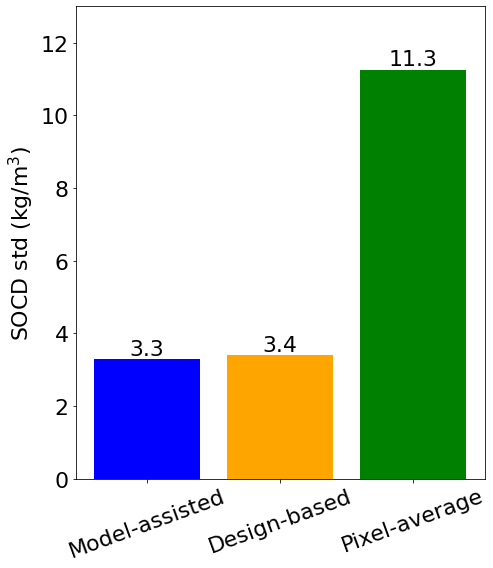

In [126]:
values = [3.287506, 3.405132, 11.263238]
methods = ['Model-assisted','Design-based', 'Pixel-average']

plt.figure(figsize=(7, 8))
bars = plt.bar(methods, values, color=['blue', 'orange', 'green'])

# Add y-axis label
plt.ylabel('SOCD std (kg/m$^3$)', fontsize=22)

# Place the value at the top of each bar, rounded to 1 decimal
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.1f}', 
             ha='center', va='bottom', fontsize=22, color='black')

# Customize tick labels and adjust their font size
plt.xticks(fontsize=22, rotation=20, ha='center')#,
plt.yticks(fontsize=22)
plt.ylim([0,13])
plt.tight_layout()
plt.savefig("/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/plot_time.series.uncertainty_compare.svg", format='svg')

In [120]:
nuts_eg['ocd_map_std'] = (nuts_eg['ocd_p975'] - nuts_eg['ocd_p025'])*factor/4

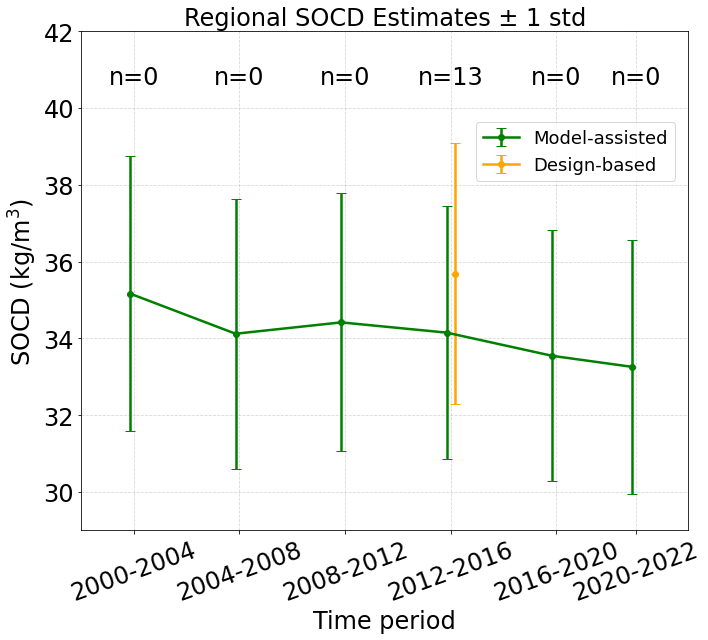

In [129]:
time = ['2000-2004','2004-2008','2008-2012','2012-2016','2016-2020','2020-2022']

plt.figure(figsize=(10, 9))

# Define offsets for the x positions to separate the two time series
x_offset = 0.15

# Plotting OCD_M with agg_std on the left side of each year
plt.errorbar(nuts_eg['year'] - x_offset, nuts_eg['ocd_m'], yerr=nuts_eg['agg_std'], fmt='-o', label='Model-assisted', capsize=5, color='green',linewidth=2.5)
# # Plotting model-based 
# plt.errorbar(nuts_eg['year'] - x_offset, nuts_eg['ocd_m'], yerr=nuts_eg['ocd_map_std'], fmt='-o', label='Model-based', capsize=5, color='blue',linewidth=2.5)
# Plotting Sample Mean with sample_std on the right side of each year
plt.errorbar(nuts_eg['year'] + x_offset, nuts_eg['sample_mean'], yerr=nuts_eg['sample_std'], fmt='-o', label='Design-based', capsize=5, color='orange',linewidth=2.5)

# Adding sample size text for each year in the middle
for i, row in nuts_eg.iterrows():
    plt.text(row['year'], 40.5, f"n={row['sample_size']:.0f}", ha='center', va='bottom', fontsize=24)

# Setting the x-ticks with time labels
plt.xticks(nuts_eg['year'], time, fontsize=24, rotation=20)
plt.yticks(fontsize=24)

# Labels, title, and legend
plt.xlabel('Time period', fontsize=24)
plt.ylabel('SOCD (kg/m$^3$)', fontsize=24)
plt.title('Regional SOCD Estimates ± 1 std', fontsize=24)
plt.legend(fontsize=18,loc=(0.65, 0.7))
plt.ylim([29, 42])
plt.xlim([2000,2023])
# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/plot_time.series.uncertainty.svg", format='svg')
plt.show()

### map visualization

In [24]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

raster_files = [
    'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p025_30m_b0cm..20cm_20120101_20161231_eu_epsg.3035_v20240804.tif',
    'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p975_30m_b0cm..20cm_20120101_20161231_eu_epsg.3035_v20240804.tif'
]

# Clip the first raster (p025)
with rasterio.open(raster_files[0]) as src:
    clipped_p025, clipped_transform = mask(src, rg.geometry, crop=True)

# Clip the second raster (p975)
with rasterio.open(raster_files[1]) as src:
    clipped_p975, _ = mask(src, rg.geometry, crop=True)

# Calculate the clipped image using the difference and factor
clipped_image = (clipped_p975 - clipped_p025) * factor / 40

# Update metadata with the correct data type and NoData value
clipped_meta = src.meta.copy()
clipped_meta.update({
    'driver': 'GTiff',
    'height': clipped_image.shape[1],
    'width': clipped_image.shape[2],
    'transform': clipped_transform,
    'dtype': 'float32'
})

# Save the resulting clipped raster
output_clipped = '/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3.eg_map_std.tif'
with rasterio.open(output_clipped, 'w', **clipped_meta) as dest:
    dest.write(clipped_image.astype('float32'))
print(f"Saved clipped raster: {output_clipped}")

Saved clipped raster: /home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3.eg_map_std.tif


In [25]:
# Save the aggregated std raster as float
agg_std = nuts_eg.loc[nuts_eg['year'] == 2014, 'agg_std'].values[0]
new_raster_data = np.ones_like(clipped_image, dtype='float32') * agg_std
new_raster_data_agg = np.where(clipped_image[0] == 0, 0, new_raster_data) 
output_new_raster = output_clipped.replace('_map_', '_agg_')
with rasterio.open(output_new_raster, 'w', **clipped_meta) as dest:
    dest.write(new_raster_data_agg)
print(f"Saved aggregated std raster as float: {output_new_raster}")

# Save the sample std raster as float
sample_std = nuts_eg.loc[nuts_eg['year'] == 2014, 'sample_std'].values[0]
new_raster_data = np.ones_like(clipped_image, dtype='float32') * sample_std
new_raster_data_sample = np.where(clipped_image[0] == 0, 0, new_raster_data) 
output_new_raster = output_clipped.replace('_map_', '_sample_')
with rasterio.open(output_new_raster, 'w', **clipped_meta) as dest:
    dest.write(new_raster_data_sample)
print(f"Saved sample std raster as float: {output_new_raster}")

Saved aggregated std raster as float: /home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3.eg_agg_std.tif
Saved sample std raster as float: /home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts3.eg_sample_std.tif


### organize Germany data
- filter only DE data
- fix the issue of double points in the same spatial location
- overlay with predicted values

In [12]:
# # # create Germany dataset
# # df = pd.read_csv(f'{folder}/data/002.2_data_whole.csv', low_memory=False)
# # dfv = df.loc[df['nuts0'].isin(['DE'])]
# # dfv = dfv.loc[dfv['hzn_dep']<=20]
# # dfv = dfv.loc[dfv['ocd_qa']>5]
# # dfv = dfv.loc[dfv['ocd'].notna()]
# # dfv.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd.de.csv',index=False)

# # read
# dfv = pd.read_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/data_ocd.de.csv', low_memory=False)

# # only keep essential ones
# cols = ['id', 'lat', 'lon', 'time', 'ref', 'nuts0','ocd','hzn_dep']
# dfv = dfv[cols]
# # dfvv = dfv.loc[dfv['hzn_dep']<20]

# # depth aggregation
# from sklearn.linear_model import LinearRegression

# # Step 1: Identify locations with multiple depths
# locations_with_different_hzn_dep = dfv.groupby(['lat', 'lon']).filter(lambda x: x['hzn_dep'].nunique() > 1)

# # Step 2: Initialize a list to store results
# results = []

# # Step 3: Iterate over each unique location
# for (lat, lon), group in locations_with_different_hzn_dep.groupby(['lat', 'lon']):
#     # Fit a linear regression model between 'hzn_dep' and 'ocd'
#     X = group['hzn_dep'].values.reshape(-1, 1)
#     y = group['ocd'].values
#     model = LinearRegression().fit(X, y)
    
#     # Predict the 'ocd' value at a depth of 10 cm
#     ocd_at_10 = model.predict(np.array([[10]]))[0]
    
#     # Use the first row's data as a template, then update 'hzn_dep' and 'ocd'
#     template_row = group.iloc[0].copy()
#     template_row['hzn_dep'] = 10
#     template_row['ocd'] = ocd_at_10
    
#     # Store the result
#     results.append(template_row)

# new_df = pd.DataFrame(results)

# dfvv = dfv.drop(index=locations_with_different_hzn_dep.index)
# dfvv = pd.concat([dfvv, new_df], ignore_index=True)

# # save files
# dfvv.to_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/data_ocd.depth.aggregated.csv', index=False)


In [13]:
# # overlay with points
# dfvv = pd.read_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/data_ocd.depth.aggregated.csv', low_memory=False)

# geometry = [Point(xy) for xy in zip(dfvv['lon'], dfvv['lat'])]

# df4326 = gpd.GeoDataFrame(dfvv, geometry=geometry, crs="EPSG:4326")
# df = df4326.to_crs("EPSG:3035")

# for year in df['time'].unique():
#     start = int((year//4)*4)
#     end = int((year//4 + 1)*4)
#     # if start != 2004:
#     #     continue
#     fn = [f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_m_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20240804.tif',
#           f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p025_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20240804.tif',
#           f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p975_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20240804.tif']
#     fp = [Path(iiii) for iiii in fn]
    
#     temp = df.loc[df['time']==year]
    
#     temp = SpaceOverlay(
#         points=temp, 
#         fn_layers=fp, verbose=True
#     ).run()
    
#     fname = ['ocd_map','ocd_p025','ocd_p975']
#     fn = [ii.split('/')[-1][0:-4] for ii in fn]
#     name_map = dict(zip(fn,fname))
#     temp = temp.rename(columns = name_map)
    
#     temp = temp.drop(columns=['overlay_id', 'geometry'])
#     temp.to_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/temp_overlap/dft_variogram.depth.aggregated_{int(year)}.csv',index=False)
    

In [14]:
# # assemble the data
# # fl = find_files('/home/opengeohub/xuemeng/work_xuemeng/soc/temp_overlap/','*.csv')
# # fl = [str(ii) for ii in fl]
# tl = []
# for year in df['time'].unique():
# #     start = int((year//4)*4)
# #     end = int((year//4 + 1)*4)
# #     fn = [f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_m_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20240804.tif',
# #           f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p025_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20240804.tif',
# #           f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p975_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20240804.tif']

    
# #     fname = ['ocd_map','ocd_p025','ocd_p975']
# #     fn = [ii.split('/')[-1][0:-4] for ii in fn]
# #     name_map = dict(zip(fn,fname))
    
    
#     # fff = f'/home/opengeohub/xuemeng/work_xuemeng/soc/temp_overlap/dft_variogram_{int(year)}.csv'
#     fff = f'/home/opengeohub/xuemeng/work_xuemeng/soc/temp_overlap/dft_variogram.depth.aggregated_{int(year)}.csv'
    
#     temp = pd.read_csv(fff)
#     # temp = temp.rename(columns = name_map)
    
#     tl.append(temp)
    
# dfv = pd.concat(tl)
# for mmm in ['ocd_map','ocd_p025','ocd_p975']:
#     dfv[mmm] = dfv[mmm]/10


# # pixel level std, assume normality
# dfv['std'] = (dfv['ocd_p975']-dfv['ocd_p025'])/4
# # standardize residual with std
# dfv['residual'] = dfv['ocd_map']-dfv['ocd']
# dfv['std_rsd'] = dfv['residual']/dfv['std']
# dfv = dfv.dropna(subset=['residual'])
# dfv.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/data_ocd.variogram.depth.aggregated.csv',index=False)


# # # check why nan exists
# # # turns out they are from city area
# # dfnan = dfv.loc[dfv[['ocd_map','ocd_p025','ocd_p975']].isnull().any(axis=1)]
# # dfnan.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/visualizaiton/nan_check.csv',index=False)

### subsample organization, 500m

In [15]:
# ## sub-sample the points
# years = [2000,2004,2008,2012,2016,2020,2022]

# fn = []
# for iy in range(1,len(years)):
#     start = years[iy-1]
#     end = years[iy]
#     fne = [f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_m_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20240804.tif',
#            f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p025_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20240804.tif',
#            f'http://192.168.1.30:8333/ai4sh-landmasked/oc/oc_iso.10694.1995.mg.cm3_p975_30m_b0cm..20cm_{start}0101_{end}1231_eu_epsg.3035_v20240804.tif']
#     fn.extend(fne)
    
# fn = [Path(ii) for ii in fn]
# sub = gpd.read_file(f'/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/nuts.eg_random.points.gpkg')
# temp = SpaceOverlay(
#         points=sub, 
#         fn_layers=fn, verbose=True
# ).run()

# fn = [str(a) for a in fn]
# fname = ['ocd_' + a.split('_')[2] + '_' + a.split('_')[5][0:4] + '.' + a.split('_')[6][0:4] for a in fn]
# fn = [ii.split('/')[-1][0:-4] for ii in fn]
# name_map = dict(zip(fn,fname))
# temp = temp.rename(columns = name_map)

# ## get the point level std
# ll = ['ocd_m_2000.2004',
#       'ocd_m_2004.2008',
#       'ocd_m_2008.2012',
#       'ocd_m_2012.2016',
#       'ocd_m_2016.2020',
#       'ocd_m_2020.2022']

# for l in ll:
#     std = l.replace('_m_','_std_')
#     pu = l.replace('_m_','_p975_')
#     pl = l.replace('_m_','_p025_')
    
#     temp[std] = (temp[pu] - temp[pl])/4
    
# temp = temp.drop(columns=['overlay_id'])
# temp.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/data_subsample.ocd.variogram.csv',index=False)


### visualization backup

In [16]:
# # # theoretical vs. experimental variogram
# # Filter the empirical data to only include distances <= 150 km
# mask_150 = filtered_binned_dist <= 300
# filtered_distances = filtered_binned_dist[mask_150]
# filtered_variograms = filtered_binned_variograms[mask_150]

# # Fit the models to the filtered empirical data
# params_spherical = fit_variogram_model(spherical_model, filtered_distances, filtered_variograms)
# params_exponential = fit_variogram_model(exponential_model, filtered_distances, filtered_variograms)
# params_gaussian = fit_variogram_model(gaussian_model, filtered_distances, filtered_variograms)

# # Generate the fitted variogram lines within the range [0, 150] km
# h_vals = np.linspace(0, 300, 500)
# fitted_variogram_spherical = spherical_model(h_vals, *params_spherical)
# fitted_variogram_exponential = exponential_model(h_vals, *params_exponential)
# fitted_variogram_gaussian = gaussian_model(h_vals, *params_gaussian)

# # Plot the empirical variogram and the fitted models
# fig, ax1 = plt.subplots(figsize=(10, 8))

# # Plot empirical variogram for the range [0, 150]
# ax1.plot(filtered_distances, filtered_variograms, marker='o', linestyle='-', color='b', label='Empirical Variogram')

# # Plot fitted models
# ax1.plot(h_vals, fitted_variogram_spherical, linestyle='--', color='g', label='Spherical Model')
# ax1.plot(h_vals, fitted_variogram_exponential, linestyle='--', color='r', label='Exponential Model')
# ax1.plot(h_vals, fitted_variogram_gaussian, linestyle='--', color='orange', label='Gaussian Model')

# ax1.set_xlabel('Distance (km)', fontsize=20)
# ax1.set_ylabel('Semi-Variance', color='b', fontsize=20)
# ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
# ax1.tick_params(axis='x', labelsize=20)
# ax1.text(0.6, 0.9, f'Bin size = {bins_size}km', 
#             ha='left', va='top', transform=ax1.transAxes, fontsize=20)  # Adjusted text position

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.bar(filtered_bin_centers[mask_150], filtered_binned_number[mask_150], width=3.5, alpha=0.2, color='r', label='Histogram')
# ax2.set_ylabel('Count of data pairs', color='r', fontsize=20)
# ax2.tick_params(axis='y', labelcolor='r', labelsize=20)

# plt.title('Variogram with Fitted Models (0-150 km)', fontsize=20)
# ax1.grid(True)
# ax1.set_xlim([0,300])

# fig.tight_layout()  # adjust subplots to fit into figure area.
# ax1.legend(loc='lower right', fontsize=15, facecolor='white', edgecolor='black', framealpha=1)
# plt.show()


In [17]:
# # # difference between std and (p975-p025)/4
# # Calculate statistics
# mean_value = dfv['ocd_map'].mean()
# std_value = dfv['ocd_map'].std()
# percentile_2_5 = np.percentile(dfv['ocd_map'], 2.5)
# percentile_97_5 = np.percentile(dfv['ocd_map'], 97.5)
# two_std_up = mean_value + 2 * std_value
# two_std_down = mean_value - 2 * std_value

# # Plot the histogram
# plt.figure(figsize=(10, 6))
# dfv['ocd_map'].hist(bins=100, alpha=0.7, color='blue')

# # Mark the percentiles
# plt.axvline(percentile_2_5, color='red', linestyle='--', linewidth=2, label='2.5th Percentile')
# plt.axvline(percentile_97_5, color='red', linestyle='--', linewidth=2, label='97.5th Percentile')

# # Mark the mean
# plt.axvline(mean_value, color='green', linestyle='-', linewidth=2, label='Mean')

# # Mark ±2 standard deviations
# plt.axvline(two_std_up, color='orange', linestyle='--', linewidth=2, label='+2 Std Dev')
# plt.axvline(two_std_down, color='orange', linestyle='--', linewidth=2, label='-2 Std Dev')

# # Set labels and title
# plt.xlabel('ocd_map', fontsize=20)
# plt.ylabel('Frequency', fontsize=20)
# plt.title(f'PI95 width: {percentile_97_5-percentile_2_5:.2f}, 4*std:{std_value*4:.2f}', fontsize=20)
# plt.legend(fontsize=18)
# # Show the plot
# plt.show()